In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import gymnasium as gym
import gym_anytrading
from gym_anytrading.envs import Actions
from gym_anytrading.envs import ForexEnv

from stable_baselines3 import A2C

import quantstats as qs
import pandas as pd
from vungo.reports import full


import os
import matplotlib.pyplot as plt

In [23]:
def my_process_data(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:, 'adjcp'].to_numpy()[start:end]
    signal_features = env.df.loc[:, ['adjcp', 'high', 'low','volume','turbulence','rsi']].to_numpy()[start:end]
    return prices, signal_features

# Refactoring the notebook code into modular functions
def load_and_preprocess_data(file_path, date_col='datadate', split_ratio=0.8):
    """
    Loads the data from a CSV file, preprocesses it, and splits it into training and testing sets.
    :param file_path: Path to the CSV file.
    :param date_col: Name of the column containing date information.
    :param split_ratio: Ratio for splitting data into training and testing sets.
    :return: A tuple of (train_df, test_df).
    """
    df = pd.read_csv(file_path)
    df[date_col] = pd.to_datetime(df[date_col], format='%Y%m%d%H%M%S')
    df.set_index(date_col, inplace=True)
    split_idx = int(split_ratio * len(df))
    train_df = df[:split_idx]
    test_df = df[split_idx:]
    return train_df, test_df

def setup_trading_environment(train_df, test_df, window_size):
    """
    Sets up the training and trading environment.

    :param train_df: DataFrame with training data.
    :param window_size: Size of the moving window for the trading environment.
    :return: Initialized trading environment.
    """
    class MyForexEnv(ForexEnv):
        _process_data = my_process_data


    start_index = window_size
    end_index = len(train_df)
    env = MyForexEnv(df=train_df, window_size=window_size, frame_bound=(start_index, end_index))

    end_trade_index = len(test_df)
    env_trade = MyForexEnv(df=test_df, window_size=window_size, frame_bound=(start_index, end_trade_index))
    return env, env_trade

def train_model(env, model_type, policy='MlpPolicy', total_timesteps=1000):
    """
    Trains a model on the given environment.

    :param env: Trading environment.
    :param model_type: Type of the model to train (e.g., A2C, DQN, etc.).
    :param policy: Policy for the model.
    :param total_timesteps: Total timesteps for training.
    :return: Trained model.
    """
    model = model_type(policy, env=env)
    model.learn(total_timesteps=total_timesteps)
    return model


def predict_actions_and_visualize(env, model, tic_name, model_name, period):
    """
    Predicts actions using the trained model and visualizes the results.

    :param env: Trading environment.
    :param model: Trained model.
    :param tic_name: Name of the ticker.
    :param model_name: Name of the model.
    :param period: Trading period information.
    :return: Action statistics and information.
    """
    action_stats = {Actions.Sell: 0, Actions.Buy: 0}
    observation, info = env.reset(seed=2023)

    while True:
        action, _states = model.predict(observation)
        action_stats[Actions(action)] += 1
        observation, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        if done:
            break

    env.close()
    # Các giá trị cần ghi
    sell_value = action_stats[Actions.Sell]
    buy_value = action_stats[Actions.Buy]
    plt.figure(figsize=(16, 6))
    env.unwrapped.render_all(f"{model_name} {tic_name} Buy: {buy_value} - Sell: {sell_value}")
    
    # Create the folder if it doesn't exist
    folder_path = f"png_result/{period}"
    os.makedirs(folder_path, exist_ok=True)
    
    # Save the plot as a PNG file with a specific name
    file_name = f"{folder_path}/{tic_name}-{model_name}-{info['total_reward']}-{info['total_profit']}.png"
    plt.savefig(file_name)
    
    # Show the plot (optional)
    plt.show()
    
    return action_stats, info


def analyze_performance(env, df,  start_index, tic_name, model_name):
    """
    Analyzes the performance of the trading strategy.

    :param env: Trading environment.
    :param start_index: Start index of the trading period.
    :param end_index: End index of the trading period.
    :param tic_name: Name of the trading instrument.
    :param model_name: Name of the model used.
    :return: Performance metrics.
    """
    net_worth = pd.Series(env.unwrapped.history['total_profit'], index=df.index[start_index+1:len(df)])
    returns = net_worth.pct_change().iloc[1:]
    metrics = full(returns, tic_name=tic_name, model_name=model_name)
    return metrics


In [27]:
list_csv=["data_d1/EURUSD1440_data.csv","data_d1/GBPUSD1440_data.csv","data_d1/USDCAD1440_data.csv","data_d1/USDCHF1440_data.csv","data_d1/USDJPY1440_data.csv"]

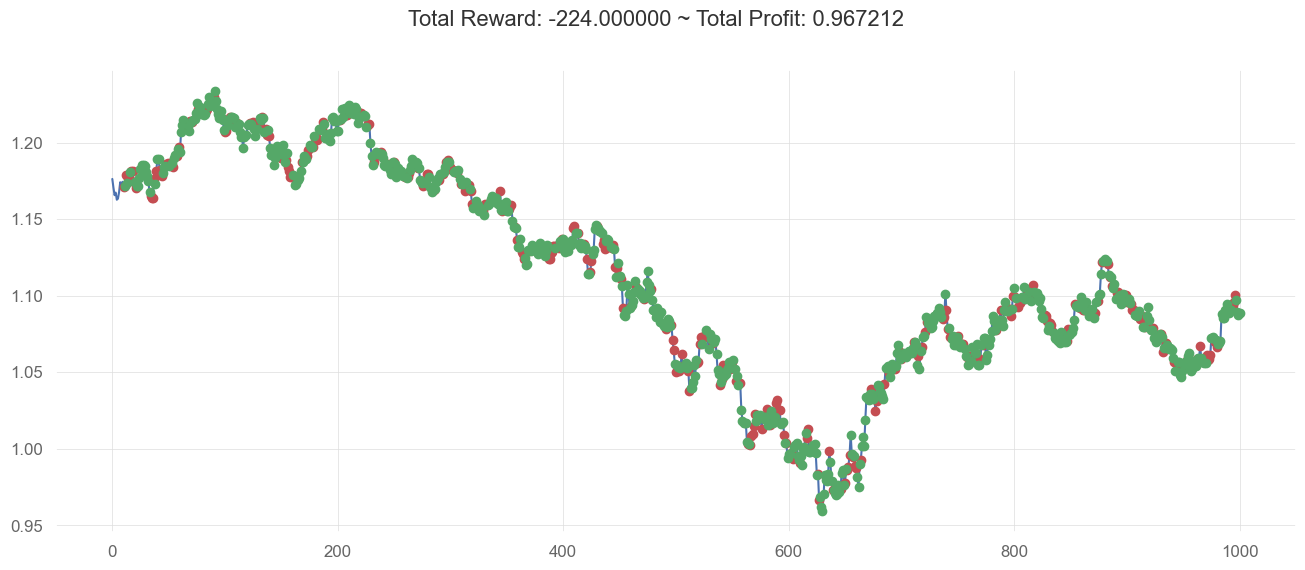

Đã ghi thông tin vào EURUSD1440-A2C.csv


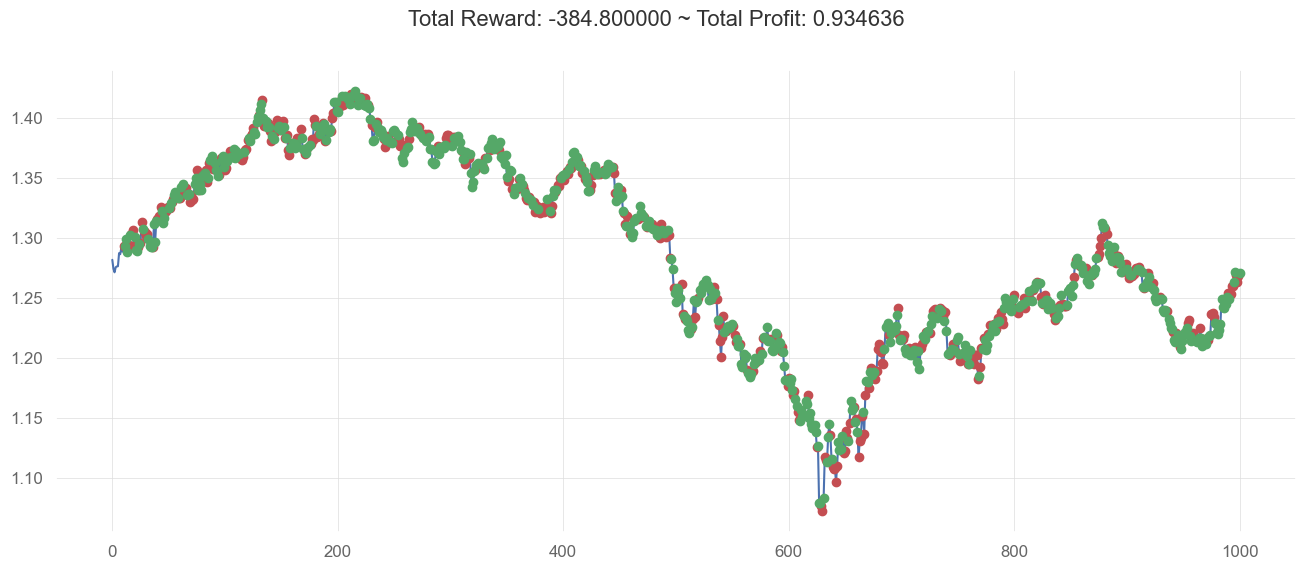

Đã ghi thông tin vào GBPUSD1440-A2C.csv


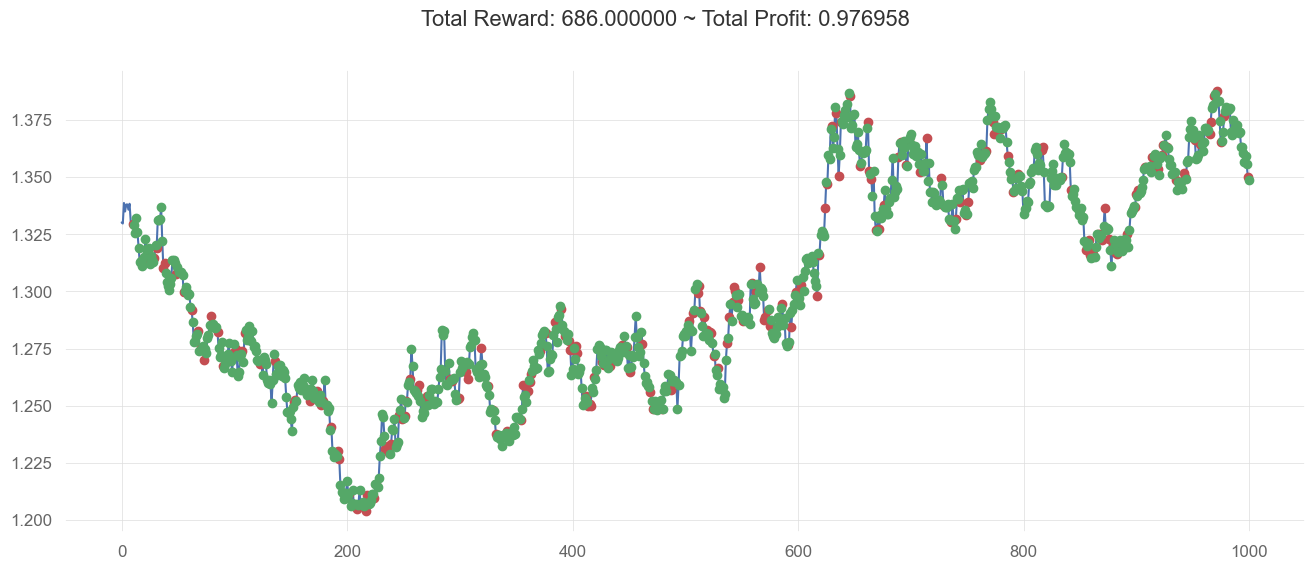

Đã ghi thông tin vào USDCAD1440-A2C.csv


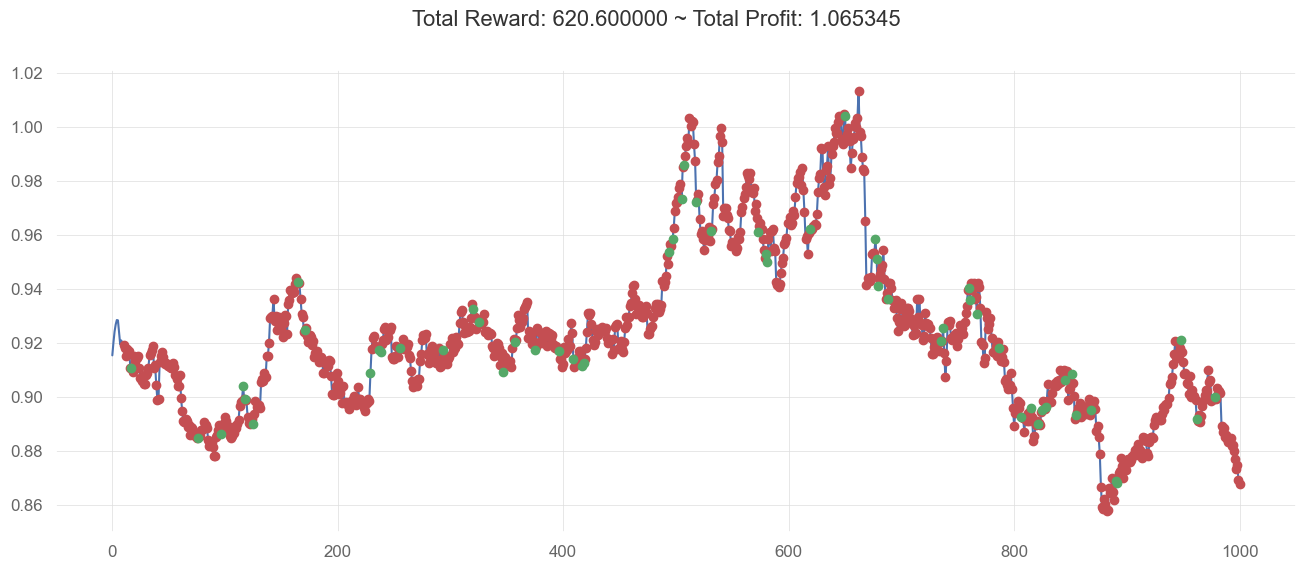

Đã ghi thông tin vào USDCHF1440-A2C.csv


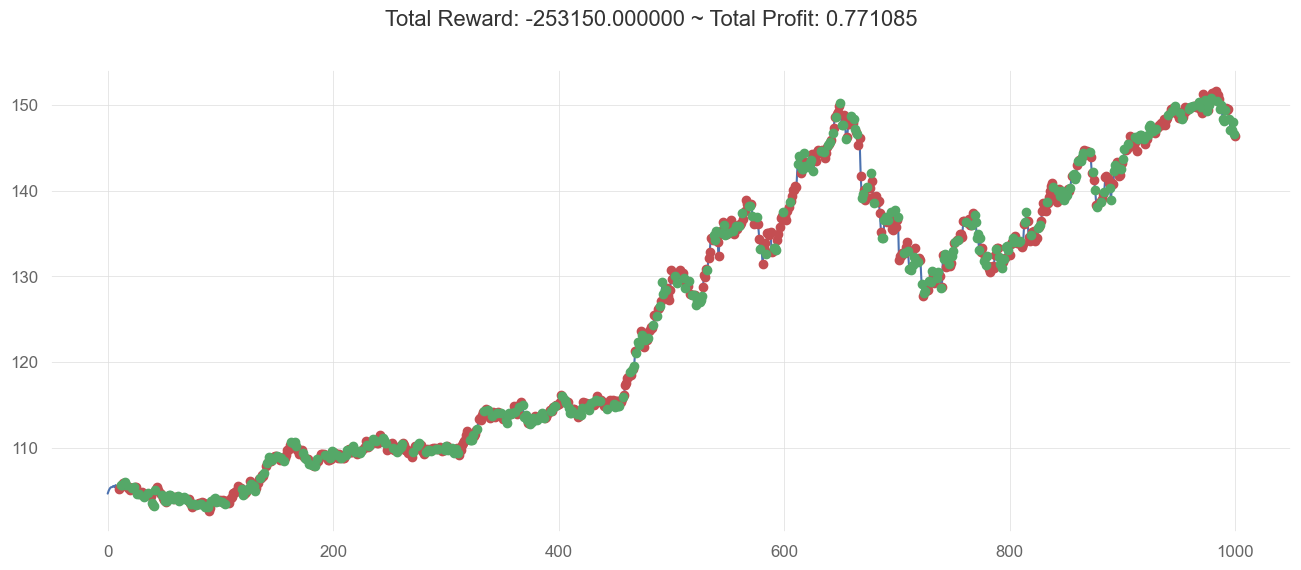

Đã ghi thông tin vào USDJPY1440-A2C.csv


c:\Users\VuND\miniconda3\envs\tradebot\lib\site-packages\stable_baselines3\common\buffers.py:241: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 0.50GB > 0.47GB
  warnings.warn(


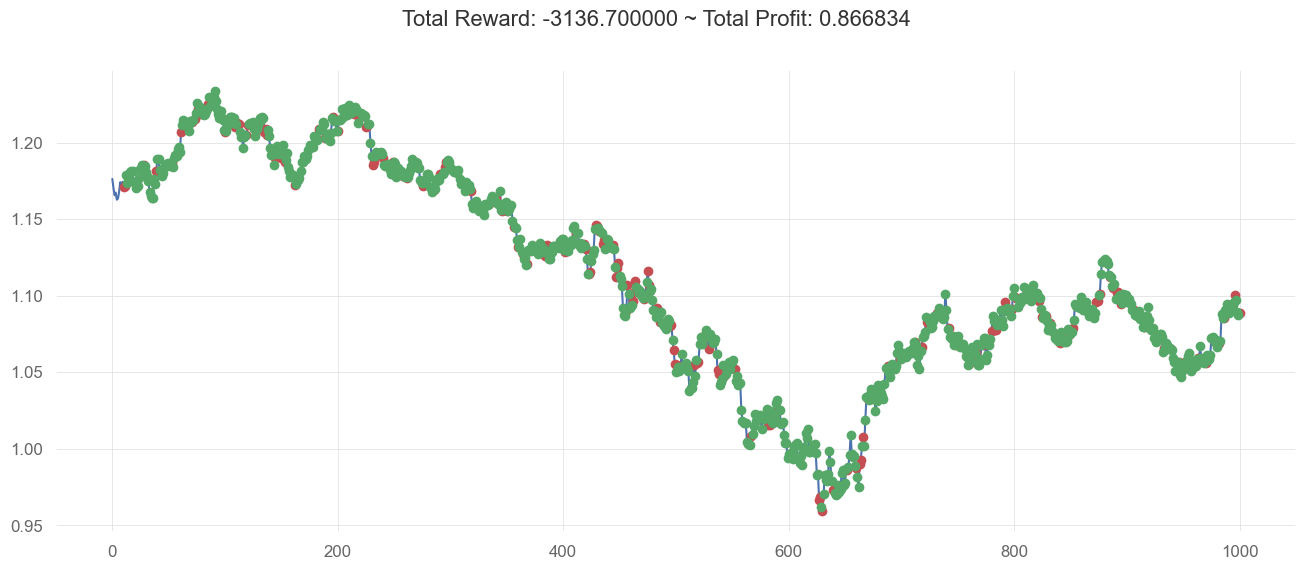

Đã ghi thông tin vào EURUSD1440-TR-DQN.csv


c:\Users\VuND\miniconda3\envs\tradebot\lib\site-packages\stable_baselines3\common\buffers.py:241: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 0.50GB > 0.43GB
  warnings.warn(


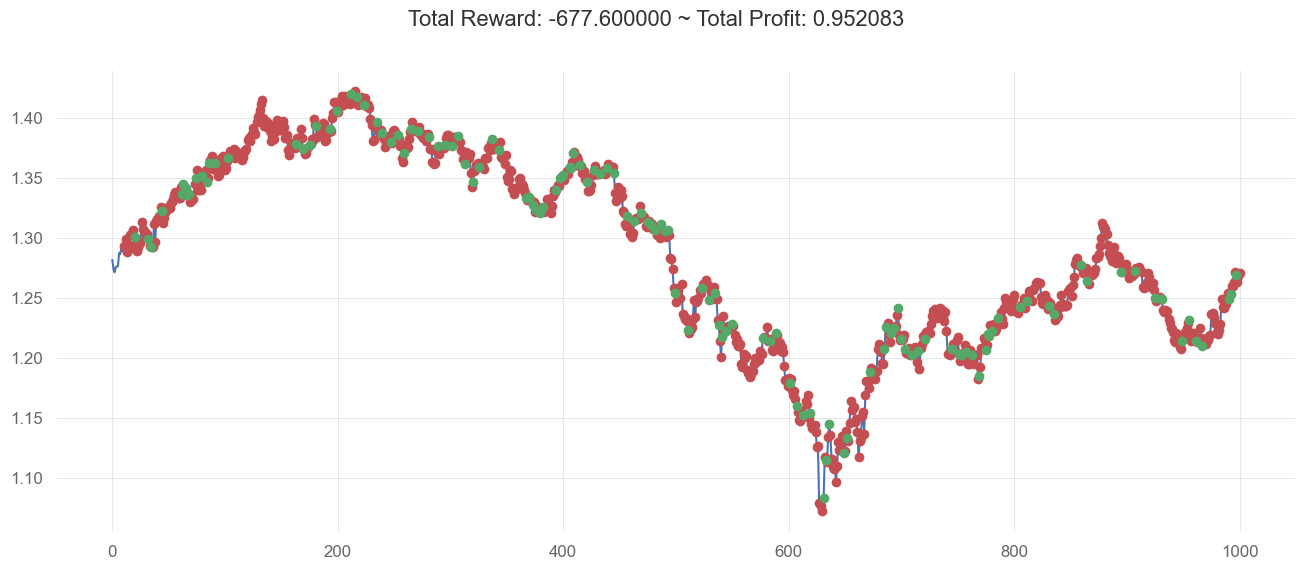

Đã ghi thông tin vào GBPUSD1440-TR-DQN.csv


c:\Users\VuND\miniconda3\envs\tradebot\lib\site-packages\stable_baselines3\common\buffers.py:241: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 0.50GB > 0.43GB
  warnings.warn(


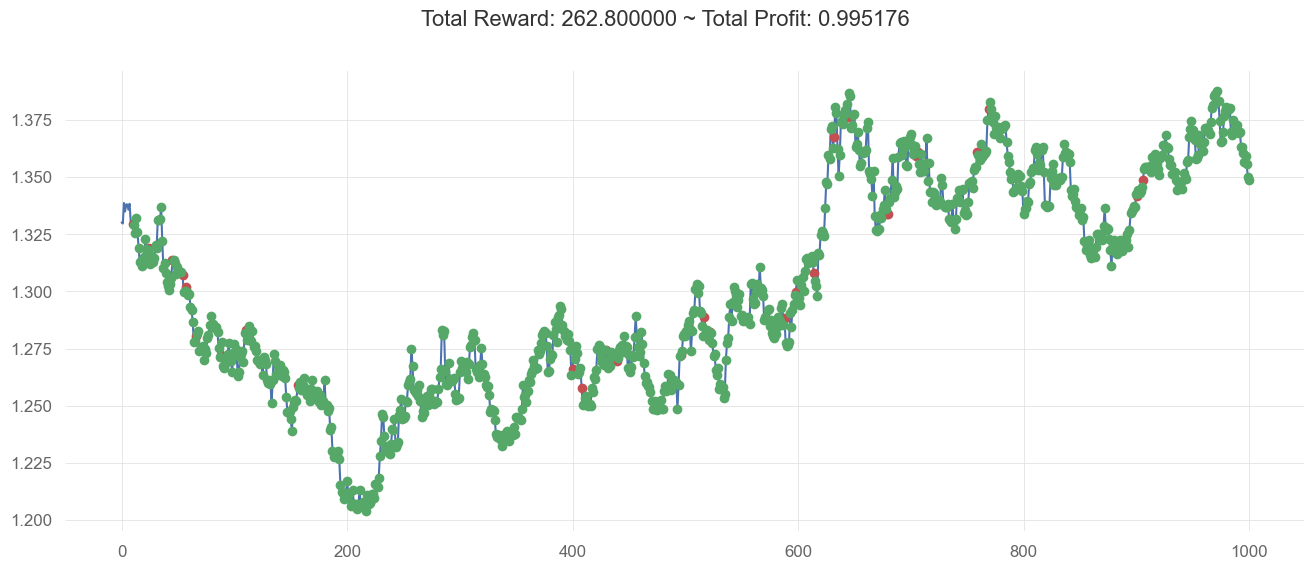

Đã ghi thông tin vào USDCAD1440-TR-DQN.csv


c:\Users\VuND\miniconda3\envs\tradebot\lib\site-packages\stable_baselines3\common\buffers.py:241: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 0.50GB > 0.41GB
  warnings.warn(


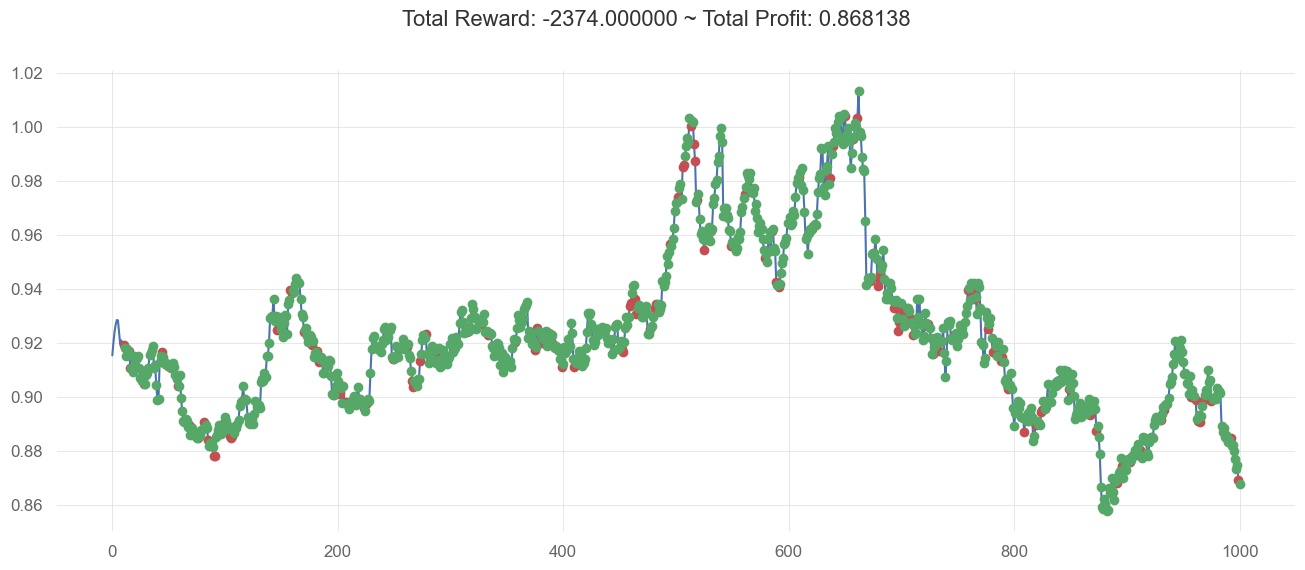

Đã ghi thông tin vào USDCHF1440-TR-DQN.csv


c:\Users\VuND\miniconda3\envs\tradebot\lib\site-packages\stable_baselines3\common\buffers.py:241: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 0.50GB > 0.45GB
  warnings.warn(


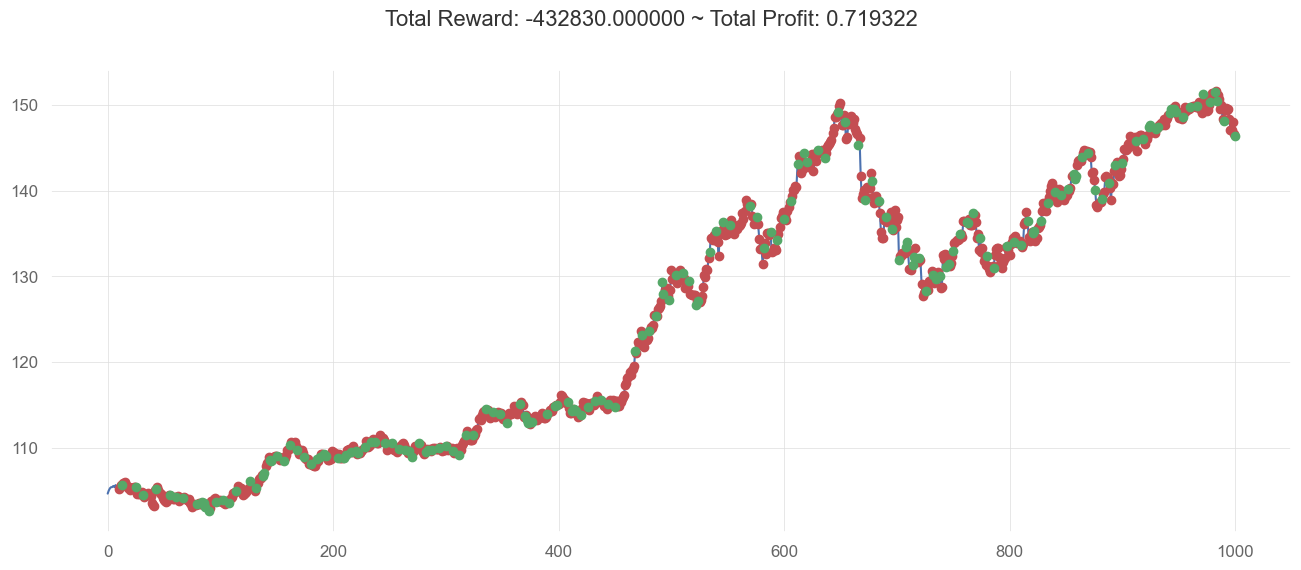

Đã ghi thông tin vào USDJPY1440-TR-DQN.csv


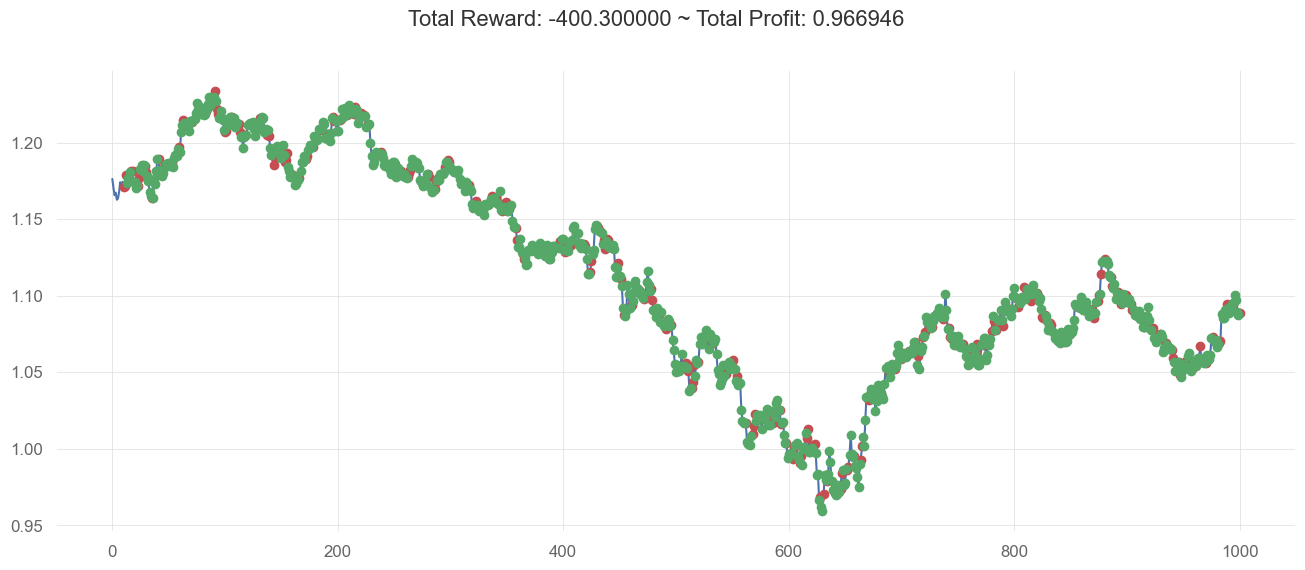

Đã ghi thông tin vào EURUSD1440-DQN.csv


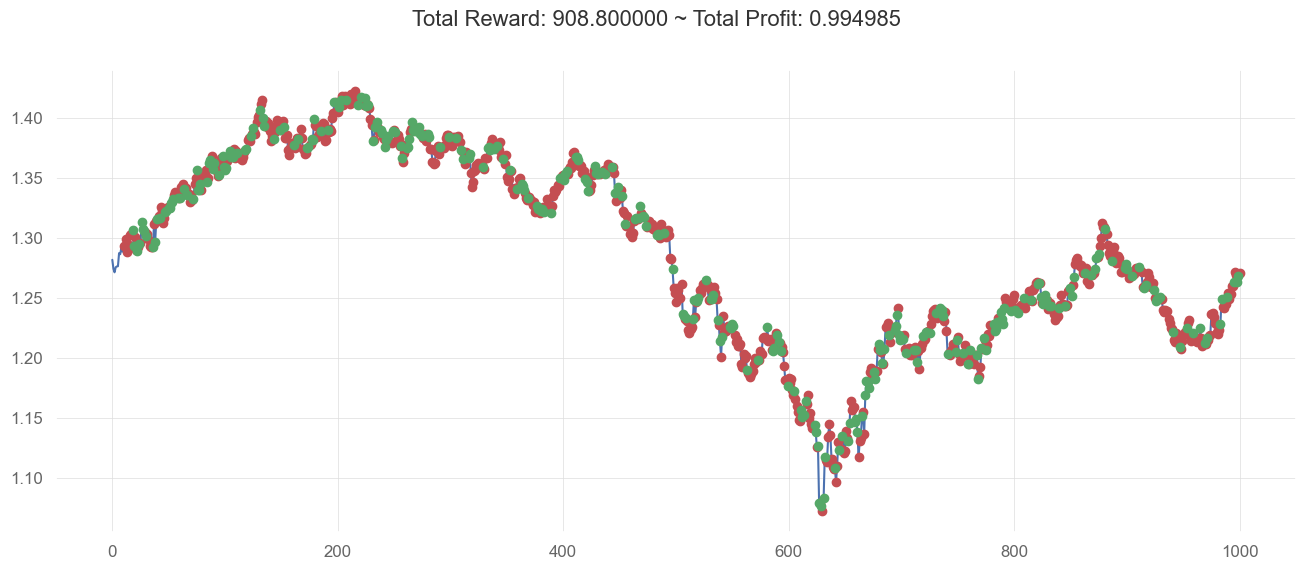

Đã ghi thông tin vào GBPUSD1440-DQN.csv


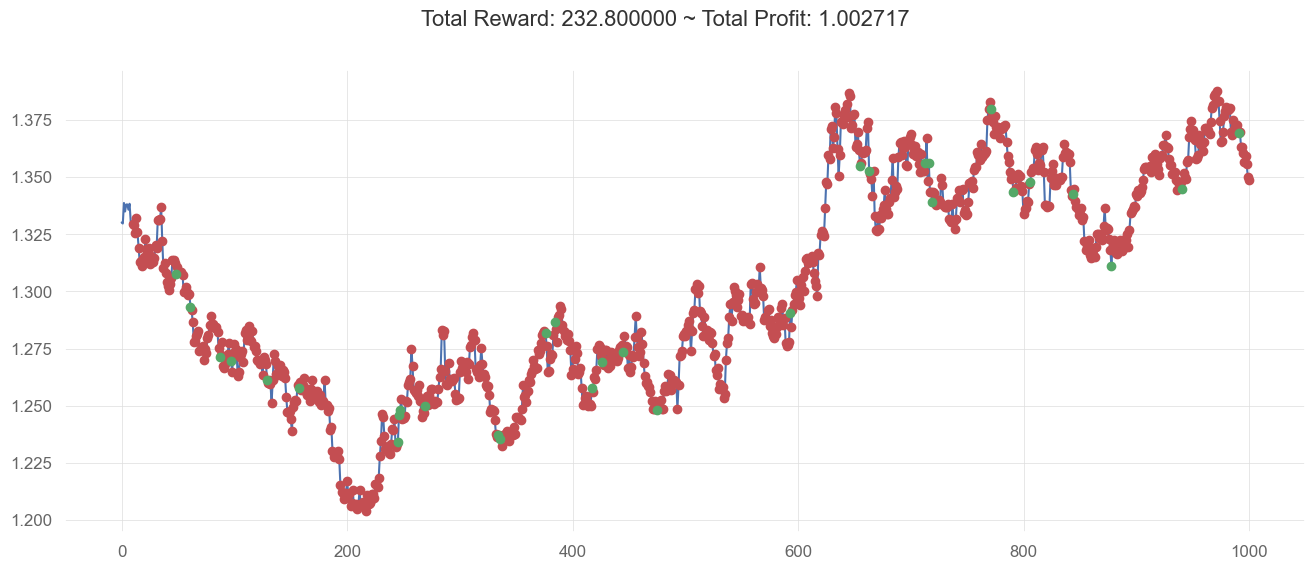

Đã ghi thông tin vào USDCAD1440-DQN.csv


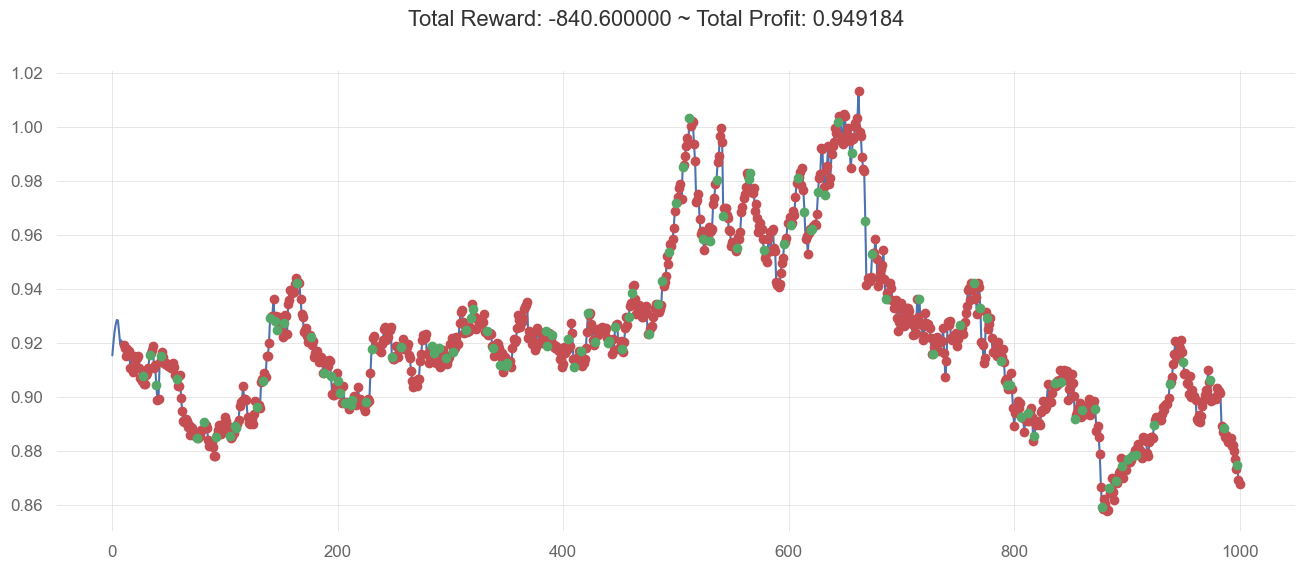

Đã ghi thông tin vào USDCHF1440-DQN.csv


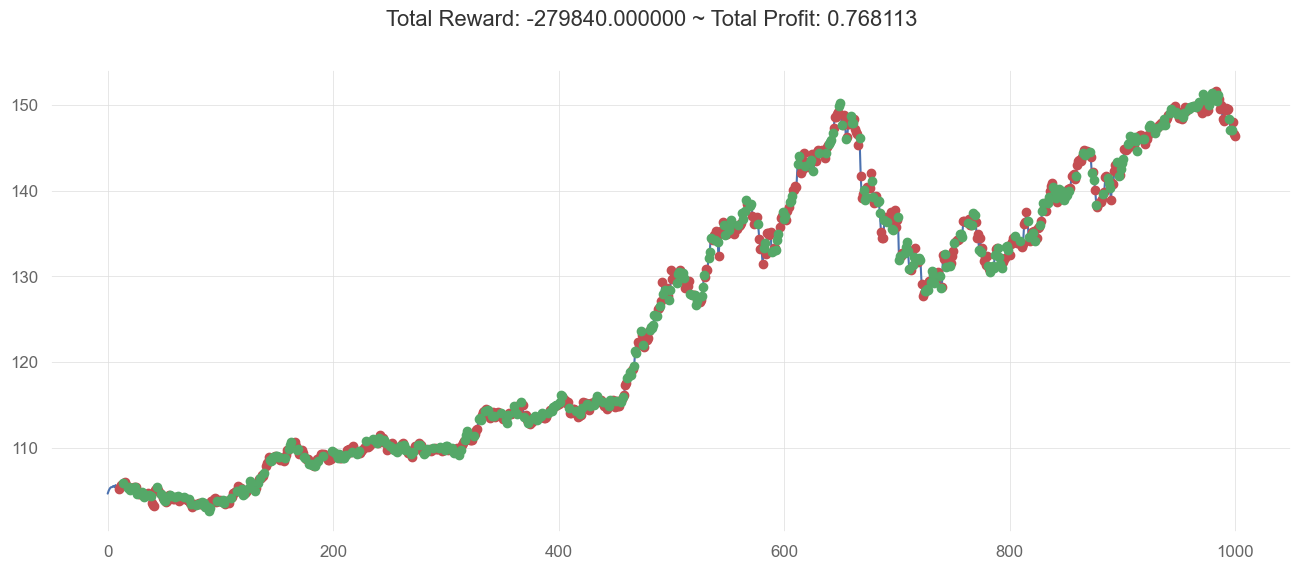

Đã ghi thông tin vào USDJPY1440-DQN.csv


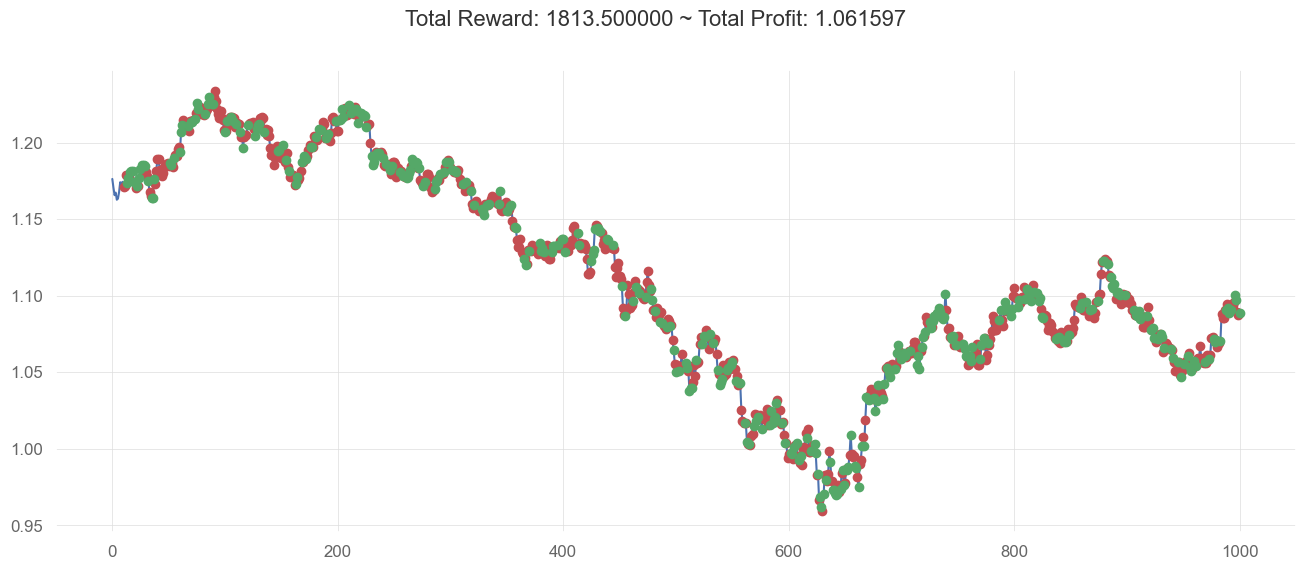

Đã ghi thông tin vào EURUSD1440-PPO.csv


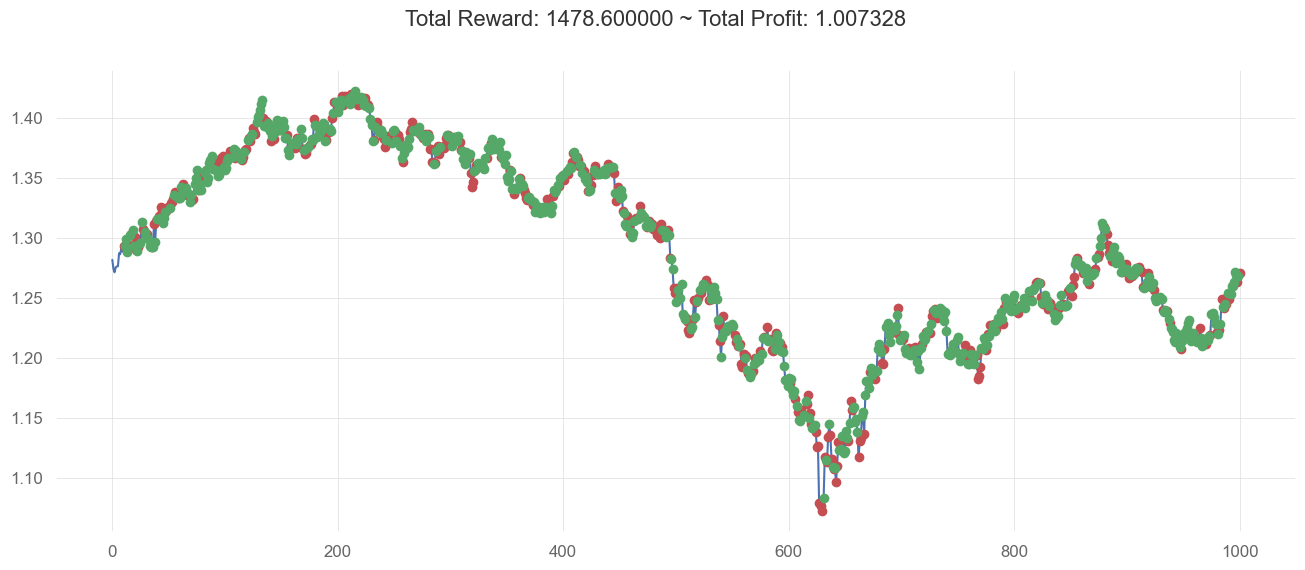

Đã ghi thông tin vào GBPUSD1440-PPO.csv


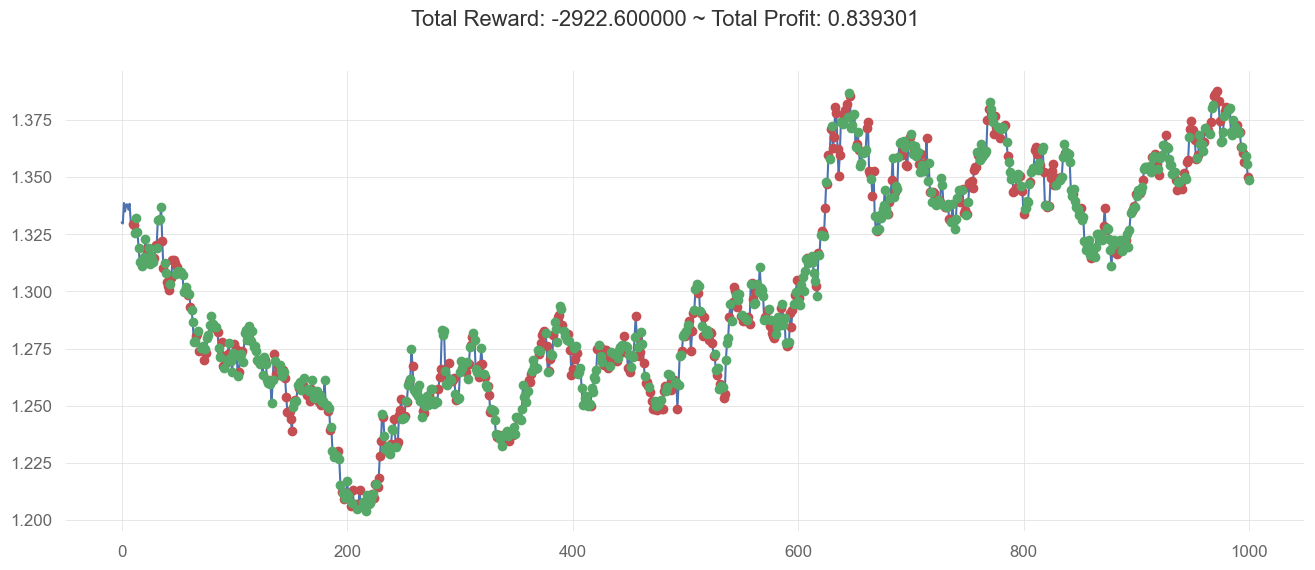

Đã ghi thông tin vào USDCAD1440-PPO.csv


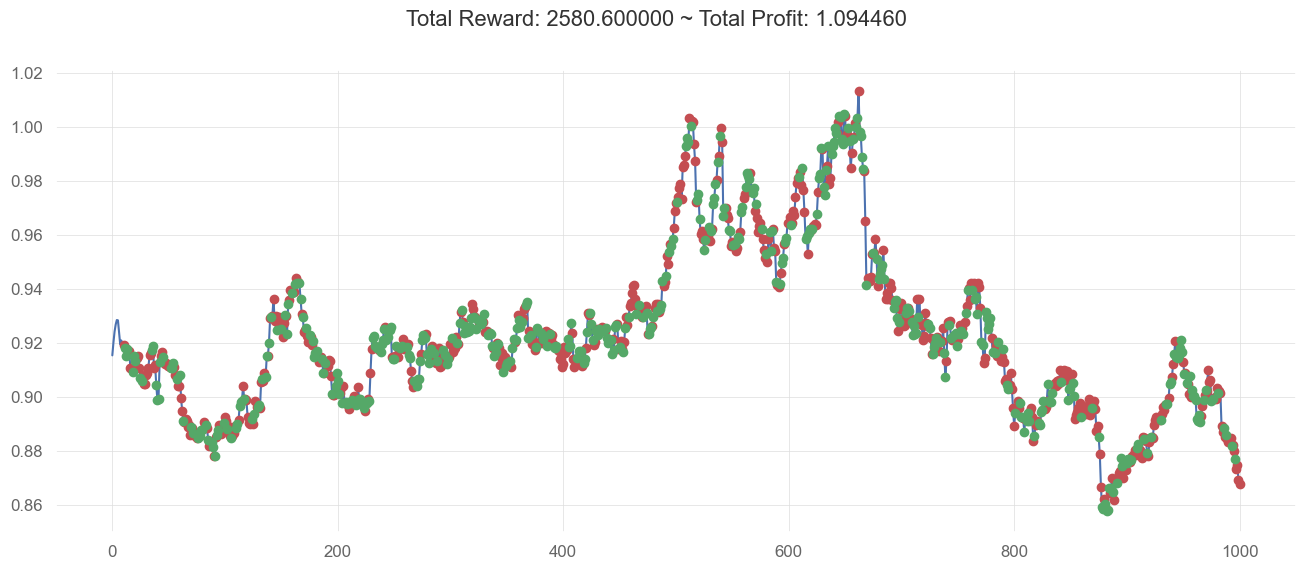

Đã ghi thông tin vào USDCHF1440-PPO.csv


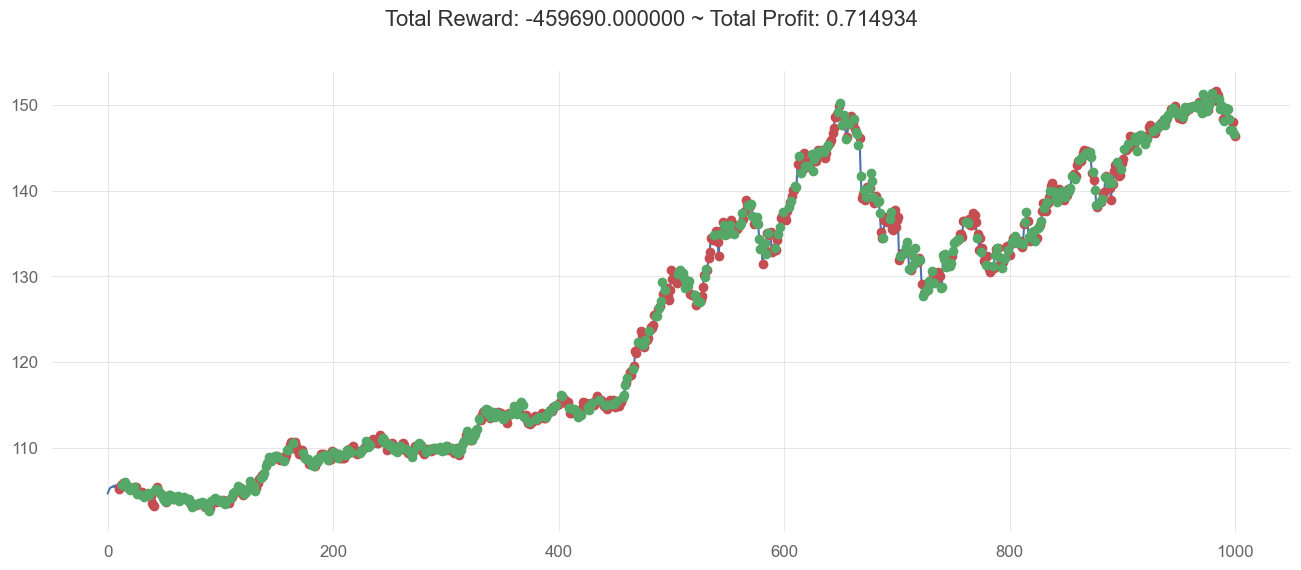

Đã ghi thông tin vào USDJPY1440-PPO.csv


In [28]:
from stable_baselines3 import PPO
from stable_baselines3.dqn.dqn import DQN
from stable_baselines3 import A2C

model_name="A2C"
for pair in list_csv:
    tic_name= pair.split("/")[1].split(".")[0].split("_")[0]
    period = pair.split("/")[0].split("_")[1]
    train_df, test_df= load_and_preprocess_data(pair)
    env_train , env_trade = setup_trading_environment(train_df=train_df, test_df=test_df, window_size=10)
    model = train_model(env_train,  model_type=A2C, total_timesteps=5000)

    action_stats,info = predict_actions_and_visualize(env=env_trade,model=model,tic_name=tic_name, model_name=model_name, period=period)
    analyze_performance(env=env_trade, start_index=10, df = test_df,model_name=model_name, tic_name=tic_name)

    # Các giá trị cần ghi
    sell_value = action_stats[Actions.Sell]
    buy_value = action_stats[Actions.Buy]
    total_reward = info["total_reward"]
    total_profit = info["total_profit"]
    import csv
    # Đường dẫn đến file CSV
    csv_file_path = f'{tic_name}-{model_name}.csv'

    # Các giá trị cần ghi
    sell_value = action_stats[Actions.Sell]
    buy_value = action_stats[Actions.Buy]
    total_reward = info["total_reward"]
    total_profit = info["total_profit"]

    # Mở file CSV ở chế độ ghi và ghi các giá trị vào file
    with open(csv_file_path, mode='a', newline='') as file:
        writer = csv.writer(file)
        
        # Ghi các giá trị vào file dưới dạng hàng mới
        writer.writerow(['Action Sell', sell_value])
        writer.writerow(['Action Buy', buy_value])
        writer.writerow(['Total Reward', total_reward])
        writer.writerow(['Total Profit', total_profit])
        writer.writerow(['Ticket', tic_name])
        writer.writerow(['Model', model_name])

    print(f"Đã ghi thông tin vào {csv_file_path}")

model_name="TR-DQN"
for pair in list_csv:
    tic_name= pair.split("/")[1].split(".")[0].split("_")[0]
    period = pair.split("/")[0].split("_")[1]
    train_df, test_df= load_and_preprocess_data(pair)
    env_train , env_trade = setup_trading_environment(train_df=train_df, test_df=test_df, window_size=10)
    model = train_model(env_train,  model_type=DQN, total_timesteps=5000)

    action_stats,info = predict_actions_and_visualize(env=env_trade,model=model,tic_name=tic_name, model_name=model_name, period=period)
    analyze_performance(env=env_trade, start_index=10, df = test_df,model_name=model_name, tic_name=tic_name)

    # Các giá trị cần ghi
    sell_value = action_stats[Actions.Sell]
    buy_value = action_stats[Actions.Buy]
    total_reward = info["total_reward"]
    total_profit = info["total_profit"]
    import csv
    # Đường dẫn đến file CSV
    csv_file_path = f'{tic_name}-{model_name}.csv'

    # Các giá trị cần ghi
    sell_value = action_stats[Actions.Sell]
    buy_value = action_stats[Actions.Buy]
    total_reward = info["total_reward"]
    total_profit = info["total_profit"]

    # Mở file CSV ở chế độ ghi và ghi các giá trị vào file
    with open(csv_file_path, mode='a', newline='') as file:
        writer = csv.writer(file)
        
        # Ghi các giá trị vào file dưới dạng hàng mới
        writer.writerow(['Action Sell', sell_value])
        writer.writerow(['Action Buy', buy_value])
        writer.writerow(['Total Reward', total_reward])
        writer.writerow(['Total Profit', total_profit])
        writer.writerow(['Ticket', tic_name])
        writer.writerow(['Model', model_name])

    print(f"Đã ghi thông tin vào {csv_file_path}")


model_name="DQN"
for pair in list_csv:
    tic_name= pair.split("/")[1].split(".")[0].split("_")[0]
    period = pair.split("/")[0].split("_")[1]
    train_df, test_df= load_and_preprocess_data(pair)
    env_train , env_trade = setup_trading_environment(train_df=train_df, test_df=test_df, window_size=10)
    model = train_model(env_train,  model_type=DQN, total_timesteps=5000)

    action_stats,info = predict_actions_and_visualize(env=env_trade,model=model,tic_name=tic_name, model_name=model_name, period=period)
    analyze_performance(env=env_trade, start_index=10, df = test_df,model_name=model_name, tic_name=tic_name)

    # Các giá trị cần ghi
    sell_value = action_stats[Actions.Sell]
    buy_value = action_stats[Actions.Buy]
    total_reward = info["total_reward"]
    total_profit = info["total_profit"]
    import csv
    # Đường dẫn đến file CSV
    csv_file_path = f'{tic_name}-{model_name}.csv'

    # Các giá trị cần ghi
    sell_value = action_stats[Actions.Sell]
    buy_value = action_stats[Actions.Buy]
    total_reward = info["total_reward"]
    total_profit = info["total_profit"]

    # Mở file CSV ở chế độ ghi và ghi các giá trị vào file
    with open(csv_file_path, mode='a', newline='') as file:
        writer = csv.writer(file)
        
        # Ghi các giá trị vào file dưới dạng hàng mới
        writer.writerow(['Action Sell', sell_value])
        writer.writerow(['Action Buy', buy_value])
        writer.writerow(['Total Reward', total_reward])
        writer.writerow(['Total Profit', total_profit])
        writer.writerow(['Ticket', tic_name])
        writer.writerow(['Model', model_name])

    print(f"Đã ghi thông tin vào {csv_file_path}")


model_name="PPO"
for pair in list_csv:
    tic_name= pair.split("/")[1].split(".")[0].split("_")[0]
    period = pair.split("/")[0].split("_")[1]
    train_df, test_df= load_and_preprocess_data(pair)
    env_train , env_trade = setup_trading_environment(train_df=train_df, test_df=test_df, window_size=10)
    model = train_model(env_train,  model_type=PPO, total_timesteps=5000)

    action_stats,info = predict_actions_and_visualize(env=env_trade,model=model,tic_name=tic_name, model_name=model_name, period=period)
    analyze_performance(env=env_trade, start_index=10, df = test_df,model_name=model_name, tic_name=tic_name)

    # Các giá trị cần ghi
    sell_value = action_stats[Actions.Sell]
    buy_value = action_stats[Actions.Buy]
    total_reward = info["total_reward"]
    total_profit = info["total_profit"]
    import csv
    # Đường dẫn đến file CSV
    csv_file_path = f'{tic_name}-{model_name}.csv'

    # Các giá trị cần ghi
    sell_value = action_stats[Actions.Sell]
    buy_value = action_stats[Actions.Buy]
    total_reward = info["total_reward"]
    total_profit = info["total_profit"]

    # Mở file CSV ở chế độ ghi và ghi các giá trị vào file
    with open(csv_file_path, mode='a', newline='') as file:
        writer = csv.writer(file)
        
        # Ghi các giá trị vào file dưới dạng hàng mới
        writer.writerow(['Action Sell', sell_value])
        writer.writerow(['Action Buy', buy_value])
        writer.writerow(['Total Reward', total_reward])
        writer.writerow(['Total Profit', total_profit])
        writer.writerow(['Ticket', tic_name])
        writer.writerow(['Model', model_name])

    print(f"Đã ghi thông tin vào {csv_file_path}")

In [7]:
trade_results_df= pd.read_csv("trade_EU_LSTM.csv")

In [8]:
trade_results_df

,Unnamed: 0,Trade Number,Action,Entry Price,Exit Price,Predicted Price,Gross Profit/Loss,Transaction Fee,Net Profit/Loss,Account balance
0,0,1,Sell,1.09949,1.10049,1.099269,-0.100,0.1,-0.200,9999.800
1,1,2,Sell,1.09967,1.10033,1.099313,-0.066,0.1,-0.166,9999.634
2,2,3,Sell,1.10021,1.09981,1.098283,0.040,0.1,-0.060,9999.574
3,3,4,Sell,1.09958,1.09930,1.095620,0.028,0.1,-0.072,9999.502
4,4,5,Sell,1.09924,1.09934,1.093520,-0.010,0.1,-0.110,9999.392
...,...,...,...,...,...,...,...,...,...,...
3944,3944,3945,Sell,1.09845,1.09906,1.088712,-0.061,0.1,-0.161,9654.212
3945,3945,3946,Sell,1.09893,1.09777,1.089258,0.116,0.1,0.016,9654.228
3946,3946,3947,Sell,1.09744,1.09849,1.089157,-0.105,0.1,-0.205,9654.023
3947,3947,3948,Sell,1.09766,1.09886,1.089670,-0.120,0.1,-0.220,9653.803


In [9]:
start_date = pd.to_datetime('2020-01-01')

# Now we'll create a date range starting from the 'start_date' with the number of periods equal to the number of trades.
trade_dates = pd.date_range(start=start_date, periods=len(trade_results_df), freq='B')  # 'B' denotes business day frequency

# Assign this date range to a new column in the DataFrame
trade_results_df['Date'] = trade_dates

# Set this new 'Date' column as the index of the DataFrame
trade_results_df.set_index('Date', inplace=True)

# Rename the index to 'date' for compatibility with QuantStats
trade_results_df.index.name = 'date'

# Now let's proceed to convert the trade results to returns and apply QuantStats.
# Calculate daily returns from the 'Net Profit/Loss' column
# Convert Net Profit/Loss to returns by dividing by the account balance of the previous day
trade_results_df['Daily Returns'] = trade_results_df['Net Profit/Loss'] / trade_results_df['Account balance'].shift(1)
trade_results_df['Daily Returns'].fillna(0, inplace=True)  # Replace NaN values with 0 for the first day

# Convert the daily returns to a pandas Series with the date as the index
daily_returns = trade_results_df['Daily Returns']

In [10]:
daily_returns

date
2020-01-01    0.000000
2020-01-02   -0.000017
2020-01-03   -0.000006
2020-01-06   -0.000007
2020-01-07   -0.000011
                ...   
2035-02-13   -0.000017
2035-02-14    0.000002
2035-02-15   -0.000021
2035-02-16   -0.000023
2035-02-19   -0.000014
Name: Daily Returns, Length: 3949, dtype: float64

In [11]:
metrics = full(daily_returns, tic_name="EURm5", model_name="LSTM")


In [28]:
data_eu_m5_path= "data_m5/EURUSD5_data.csv"
data_eu_h1_path= "data_h1/EURUSD60_data.csv"
data_eu_d1_path= "data_d1/EURUSD1440_data.csv"
pair = data_eu_h1_path


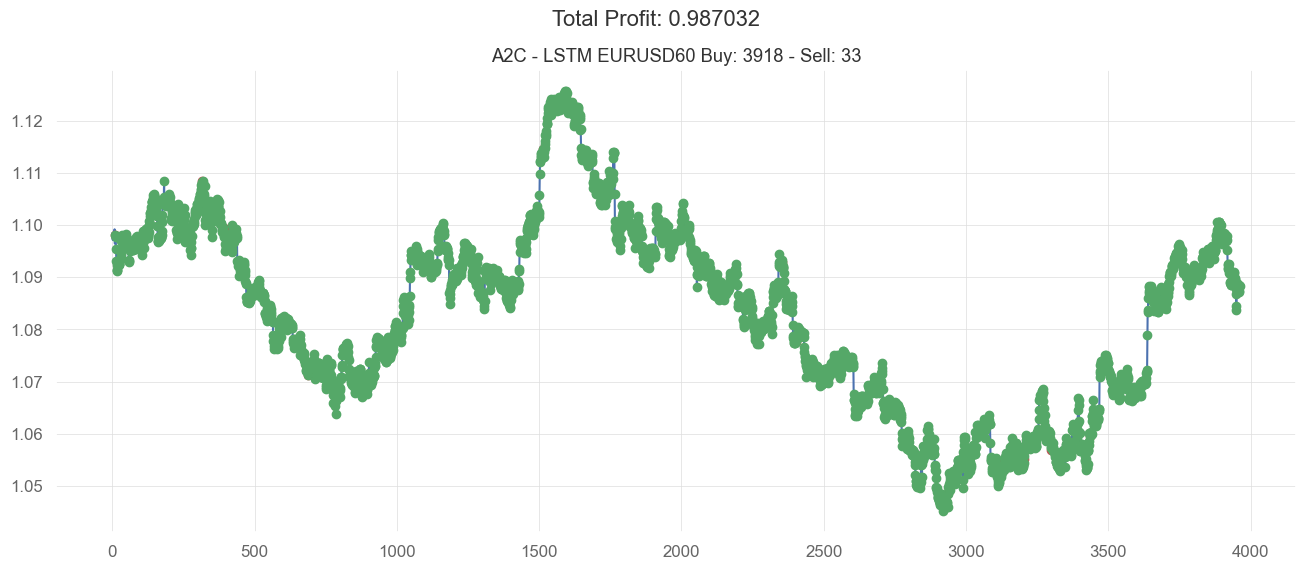

Đã ghi thông tin vào EURUSD60-A2C - LSTM.csv


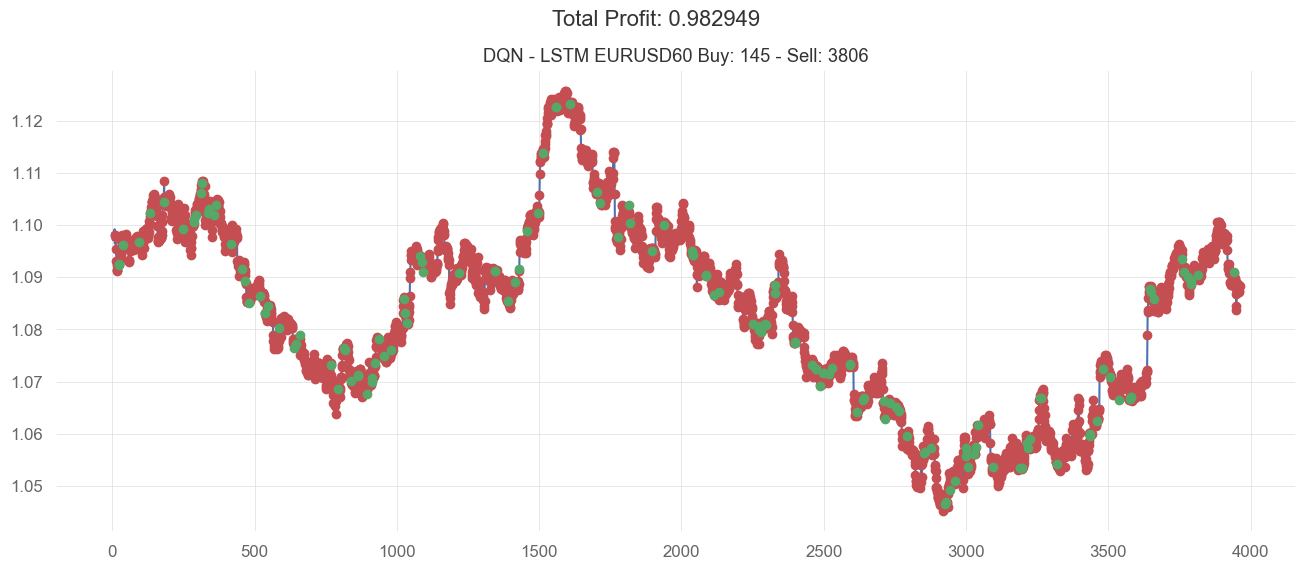

Đã ghi thông tin vào EURUSD60-DQN - LSTM.csv


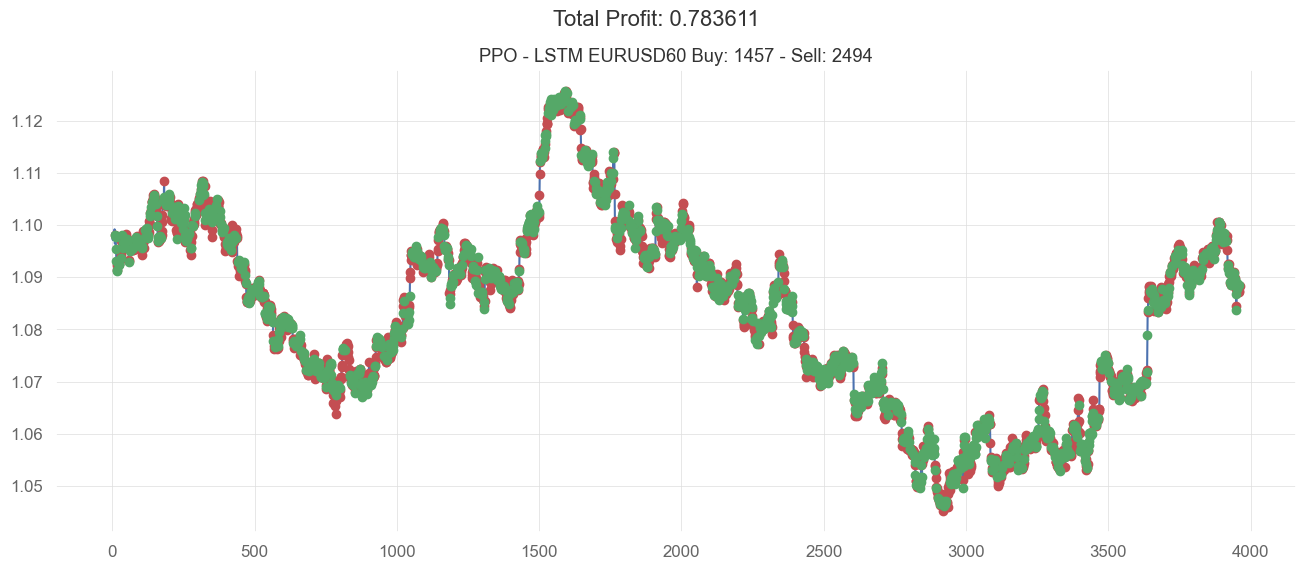

Đã ghi thông tin vào EURUSD60-PPO - LSTM.csv


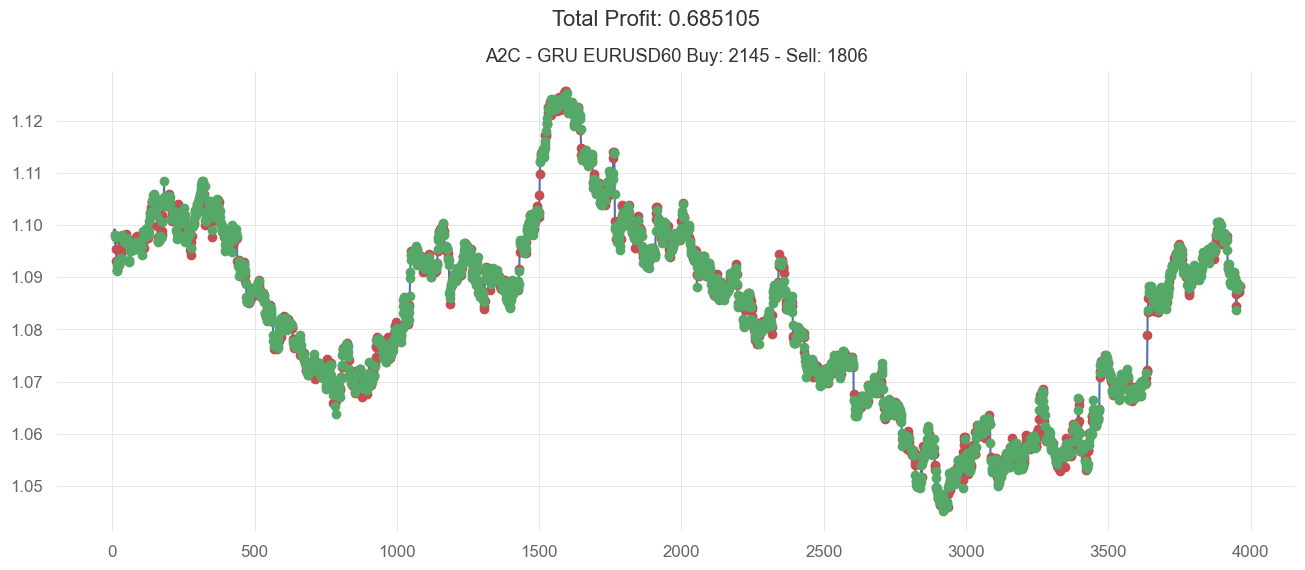

Đã ghi thông tin vào EURUSD60-A2C - GRU.csv


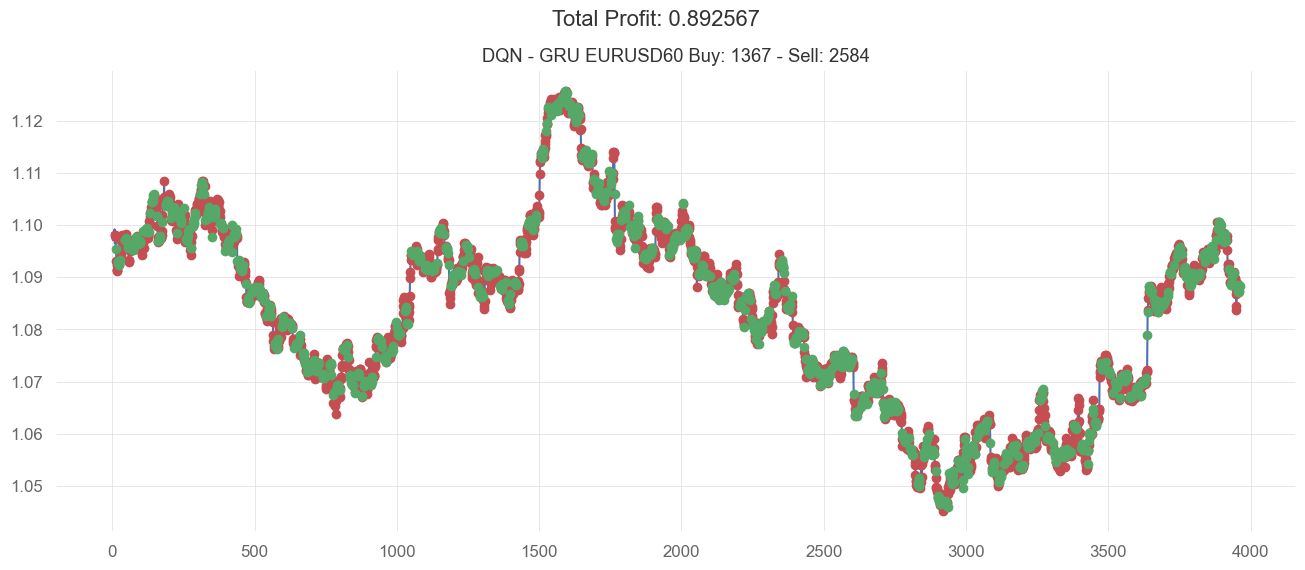

KeyboardInterrupt: 

In [29]:
from stable_baselines3 import PPO
from stable_baselines3.dqn.dqn import DQN
from stable_baselines3 import A2C
model_name="A2C - LSTM"
tic_name= pair.split("/")[1].split(".")[0].split("_")[0]
period = pair.split("/")[0].split("_")[1]
train_df, test_df= load_and_preprocess_data(pair)
env_train , env_trade = setup_trading_environment(train_df=train_df, test_df=test_df, window_size=10)
model = train_model(env_train,  model_type=A2C, total_timesteps=5000)

action_stats,info = predict_actions_and_visualize(env=env_trade,model=model,tic_name=tic_name, model_name=model_name, period=period)
analyze_performance(env=env_trade, start_index=10, df = test_df,model_name=model_name, tic_name=tic_name)

# Các giá trị cần ghi
sell_value = action_stats[Actions.Sell]
buy_value = action_stats[Actions.Buy]
total_reward = info["total_reward"]
total_profit = info["total_profit"]
import csv
# Đường dẫn đến file CSV
csv_file_path = f'{tic_name}-{model_name}.csv'

# Các giá trị cần ghi
sell_value = action_stats[Actions.Sell]
buy_value = action_stats[Actions.Buy]
total_reward = info["total_reward"]
total_profit = info["total_profit"]

# Mở file CSV ở chế độ ghi và ghi các giá trị vào file
with open(csv_file_path, mode='a', newline='') as file:
    writer = csv.writer(file)
    
    # Ghi các giá trị vào file dưới dạng hàng mới
    writer.writerow(['Action Sell', sell_value])
    writer.writerow(['Action Buy', buy_value])
    writer.writerow(['Total Reward', total_reward])
    writer.writerow(['Total Profit', total_profit])
    writer.writerow(['Ticket', tic_name])
    writer.writerow(['Model', model_name])

print(f"Đã ghi thông tin vào {csv_file_path}")


model_name="DQN - LSTM"
tic_name= pair.split("/")[1].split(".")[0].split("_")[0]
period = pair.split("/")[0].split("_")[1]
train_df, test_df= load_and_preprocess_data(pair)
env_train , env_trade = setup_trading_environment(train_df=train_df, test_df=test_df, window_size=10)
model = train_model(env_train,  model_type=DQN, total_timesteps=5000)

action_stats,info = predict_actions_and_visualize(env=env_trade,model=model,tic_name=tic_name, model_name=model_name, period=period)
analyze_performance(env=env_trade, start_index=10, df = test_df,model_name=model_name, tic_name=tic_name)

# Các giá trị cần ghi
sell_value = action_stats[Actions.Sell]
buy_value = action_stats[Actions.Buy]
total_reward = info["total_reward"]
total_profit = info["total_profit"]
import csv
# Đường dẫn đến file CSV
csv_file_path = f'{tic_name}-{model_name}.csv'

# Các giá trị cần ghi
sell_value = action_stats[Actions.Sell]
buy_value = action_stats[Actions.Buy]
total_reward = info["total_reward"]
total_profit = info["total_profit"]

# Mở file CSV ở chế độ ghi và ghi các giá trị vào file
with open(csv_file_path, mode='a', newline='') as file:
    writer = csv.writer(file)
    
    # Ghi các giá trị vào file dưới dạng hàng mới
    writer.writerow(['Action Sell', sell_value])
    writer.writerow(['Action Buy', buy_value])
    writer.writerow(['Total Reward', total_reward])
    writer.writerow(['Total Profit', total_profit])
    writer.writerow(['Ticket', tic_name])
    writer.writerow(['Model', model_name])

print(f"Đã ghi thông tin vào {csv_file_path}")


model_name="PPO - LSTM"
tic_name= pair.split("/")[1].split(".")[0].split("_")[0]
period = pair.split("/")[0].split("_")[1]
train_df, test_df= load_and_preprocess_data(pair)
env_train , env_trade = setup_trading_environment(train_df=train_df, test_df=test_df, window_size=10)
model = train_model(env_train,  model_type=PPO, total_timesteps=5000)

action_stats,info = predict_actions_and_visualize(env=env_trade,model=model,tic_name=tic_name, model_name=model_name, period=period)
analyze_performance(env=env_trade, start_index=10, df = test_df,model_name=model_name, tic_name=tic_name)

# Các giá trị cần ghi
sell_value = action_stats[Actions.Sell]
buy_value = action_stats[Actions.Buy]
total_reward = info["total_reward"]
total_profit = info["total_profit"]
import csv
# Đường dẫn đến file CSV
csv_file_path = f'{tic_name}-{model_name}.csv'

# Các giá trị cần ghi
sell_value = action_stats[Actions.Sell]
buy_value = action_stats[Actions.Buy]
total_reward = info["total_reward"]
total_profit = info["total_profit"]

# Mở file CSV ở chế độ ghi và ghi các giá trị vào file
with open(csv_file_path, mode='a', newline='') as file:
    writer = csv.writer(file)
    
    # Ghi các giá trị vào file dưới dạng hàng mới
    writer.writerow(['Action Sell', sell_value])
    writer.writerow(['Action Buy', buy_value])
    writer.writerow(['Total Reward', total_reward])
    writer.writerow(['Total Profit', total_profit])
    writer.writerow(['Ticket', tic_name])
    writer.writerow(['Model', model_name])

print(f"Đã ghi thông tin vào {csv_file_path}")


from stable_baselines3 import PPO
from stable_baselines3.dqn.dqn import DQN
from stable_baselines3 import A2C

model_name="A2C - GRU"
tic_name= pair.split("/")[1].split(".")[0].split("_")[0]
period = pair.split("/")[0].split("_")[1]
train_df, test_df= load_and_preprocess_data(pair)
env_train , env_trade = setup_trading_environment(train_df=train_df, test_df=test_df, window_size=10)
model = train_model(env_train,  model_type=A2C, total_timesteps=5000)

action_stats,info = predict_actions_and_visualize(env=env_trade,model=model,tic_name=tic_name, model_name=model_name, period=period)
analyze_performance(env=env_trade, start_index=10, df = test_df,model_name=model_name, tic_name=tic_name)

# Các giá trị cần ghi
sell_value = action_stats[Actions.Sell]
buy_value = action_stats[Actions.Buy]
total_reward = info["total_reward"]
total_profit = info["total_profit"]
import csv
# Đường dẫn đến file CSV
csv_file_path = f'{tic_name}-{model_name}.csv'

# Các giá trị cần ghi
sell_value = action_stats[Actions.Sell]
buy_value = action_stats[Actions.Buy]
total_reward = info["total_reward"]
total_profit = info["total_profit"]

# Mở file CSV ở chế độ ghi và ghi các giá trị vào file
with open(csv_file_path, mode='a', newline='') as file:
    writer = csv.writer(file)
    
    # Ghi các giá trị vào file dưới dạng hàng mới
    writer.writerow(['Action Sell', sell_value])
    writer.writerow(['Action Buy', buy_value])
    writer.writerow(['Total Reward', total_reward])
    writer.writerow(['Total Profit', total_profit])
    writer.writerow(['Ticket', tic_name])
    writer.writerow(['Model', model_name])

print(f"Đã ghi thông tin vào {csv_file_path}")


model_name="DQN - GRU"
tic_name= pair.split("/")[1].split(".")[0].split("_")[0]
period = pair.split("/")[0].split("_")[1]
train_df, test_df= load_and_preprocess_data(pair)
env_train , env_trade = setup_trading_environment(train_df=train_df, test_df=test_df, window_size=10)
model = train_model(env_train,  model_type=DQN, total_timesteps=5000)

action_stats,info = predict_actions_and_visualize(env=env_trade,model=model,tic_name=tic_name, model_name=model_name, period=period)
analyze_performance(env=env_trade, start_index=10, df = test_df,model_name=model_name, tic_name=tic_name)

# Các giá trị cần ghi
sell_value = action_stats[Actions.Sell]
buy_value = action_stats[Actions.Buy]
total_reward = info["total_reward"]
total_profit = info["total_profit"]
import csv
# Đường dẫn đến file CSV
csv_file_path = f'{tic_name}-{model_name}.csv'

# Các giá trị cần ghi
sell_value = action_stats[Actions.Sell]
buy_value = action_stats[Actions.Buy]
total_reward = info["total_reward"]
total_profit = info["total_profit"]

# Mở file CSV ở chế độ ghi và ghi các giá trị vào file
with open(csv_file_path, mode='a', newline='') as file:
    writer = csv.writer(file)
    
    # Ghi các giá trị vào file dưới dạng hàng mới
    writer.writerow(['Action Sell', sell_value])
    writer.writerow(['Action Buy', buy_value])
    writer.writerow(['Total Reward', total_reward])
    writer.writerow(['Total Profit', total_profit])
    writer.writerow(['Ticket', tic_name])
    writer.writerow(['Model', model_name])

print(f"Đã ghi thông tin vào {csv_file_path}")


model_name="PPO - GRU"
tic_name= pair.split("/")[1].split(".")[0].split("_")[0]
period = pair.split("/")[0].split("_")[1]
train_df, test_df= load_and_preprocess_data(pair)
env_train , env_trade = setup_trading_environment(train_df=train_df, test_df=test_df, window_size=10)
model = train_model(env_train,  model_type=PPO, total_timesteps=5000)

action_stats,info = predict_actions_and_visualize(env=env_trade,model=model,tic_name=tic_name, model_name=model_name, period=period)
analyze_performance(env=env_trade, start_index=10, df = test_df,model_name=model_name, tic_name=tic_name)

# Các giá trị cần ghi
sell_value = action_stats[Actions.Sell]
buy_value = action_stats[Actions.Buy]
total_reward = info["total_reward"]
total_profit = info["total_profit"]
import csv
# Đường dẫn đến file CSV
csv_file_path = f'{tic_name}-{model_name}.csv'

# Các giá trị cần ghi
sell_value = action_stats[Actions.Sell]
buy_value = action_stats[Actions.Buy]
total_reward = info["total_reward"]
total_profit = info["total_profit"]

# Mở file CSV ở chế độ ghi và ghi các giá trị vào file
with open(csv_file_path, mode='a', newline='') as file:
    writer = csv.writer(file)
    
    # Ghi các giá trị vào file dưới dạng hàng mới
    writer.writerow(['Action Sell', sell_value])
    writer.writerow(['Action Buy', buy_value])
    writer.writerow(['Total Reward', total_reward])
    writer.writerow(['Total Profit', total_profit])
    writer.writerow(['Ticket', tic_name])
    writer.writerow(['Model', model_name])

print(f"Đã ghi thông tin vào {csv_file_path}")

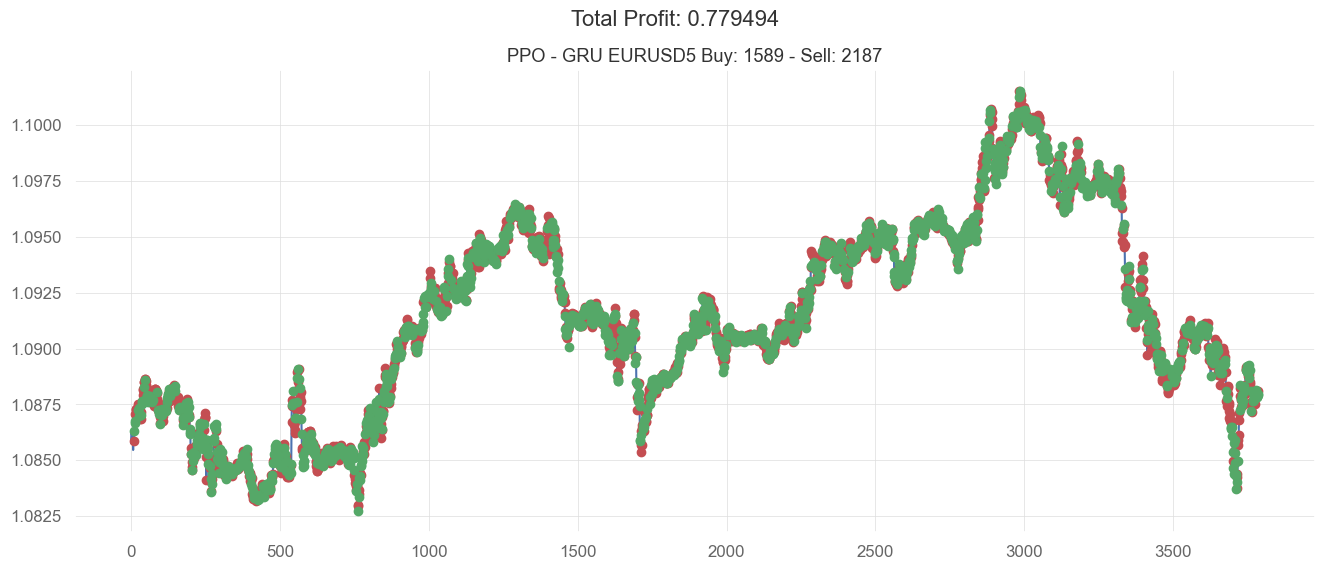

                           Strategy
-------------------------  ----------
Start Period               2023-11-14
End Period                 2023-12-01
Risk-Free Rate             0.0%
Time in Market             25.0%

Cumulative Return          -22.0%
CAGR﹪                     -97.49%

Sharpe                     -4.95
Prob. Sharpe Ratio         0.0%
Smart Sharpe               -4.49
Sortino                    -5.09
Smart Sortino              -4.62
Sortino/√2                 -3.6
Smart Sortino/√2           -3.26
Omega                      0.13

Max Drawdown               -22.0%
Longest DD Days            18
Volatility (ann.)          0.33%
Calmar                     -4.43
Skew                       -1.94
Kurtosis                   20.74

Expected Daily %           -0.01%
Expected Monthly %         -11.68%
Expected Yearly %          -22.0%
Kelly Criterion            -94.64%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.04%
Expected Shortfall (cVaR)  -0.04%

Max Consecutive W

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2023-11-14,2023-12-01,2023-12-01,18,-22.00254,-21.758411


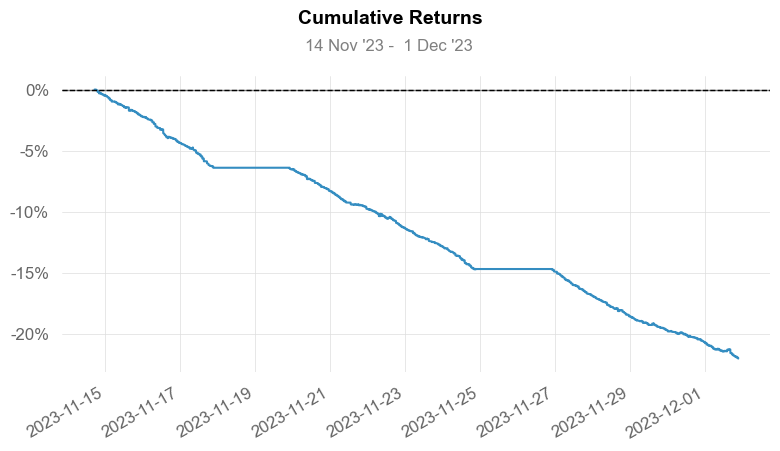

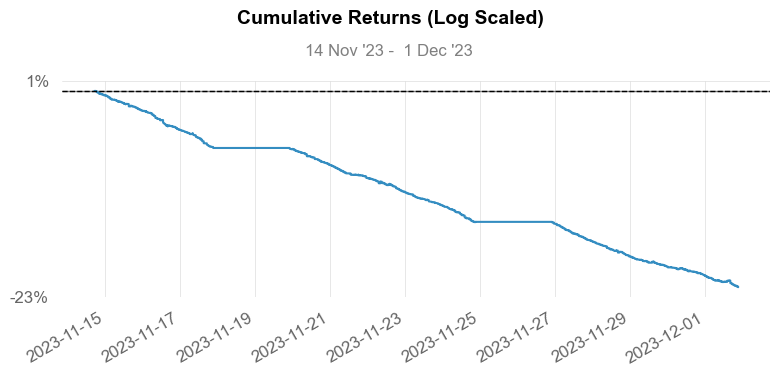

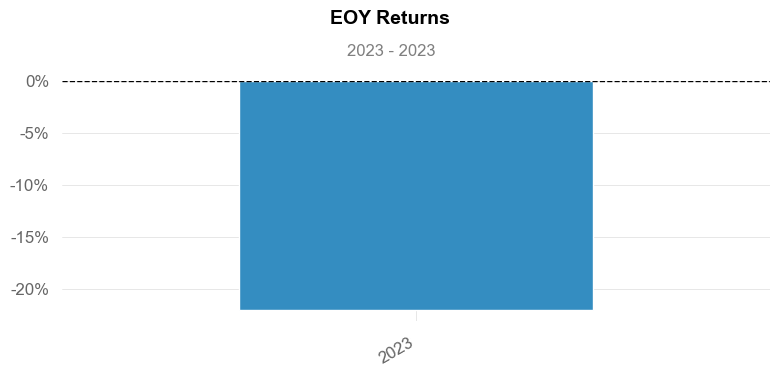

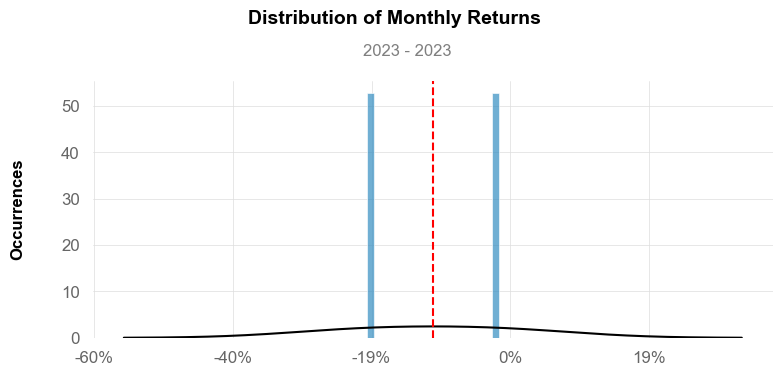

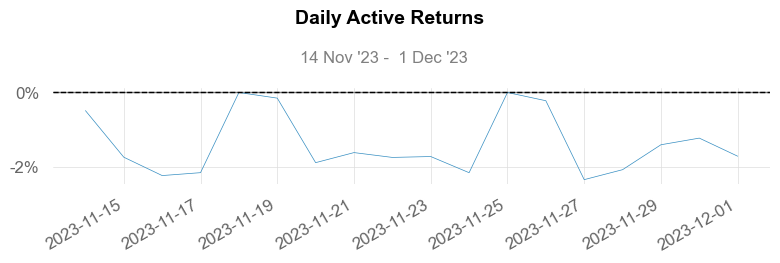

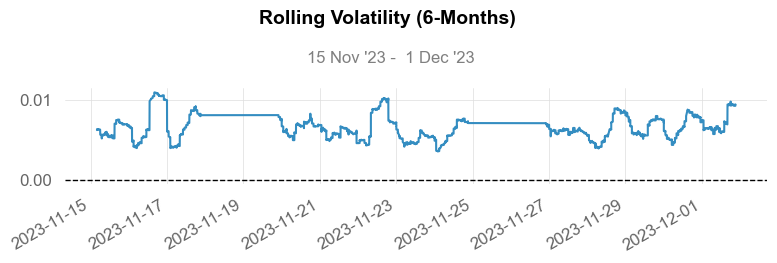

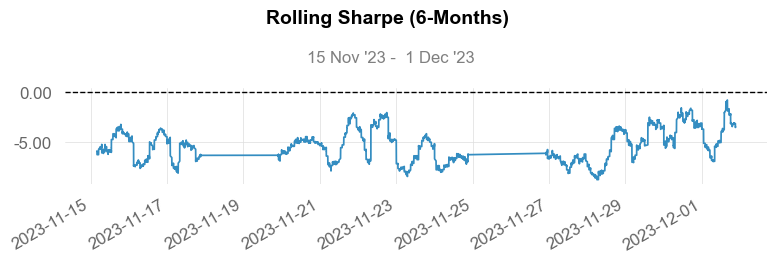

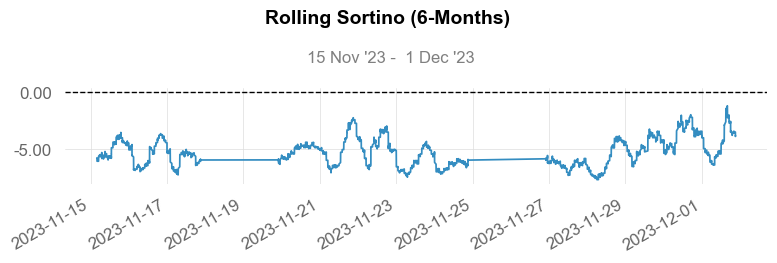

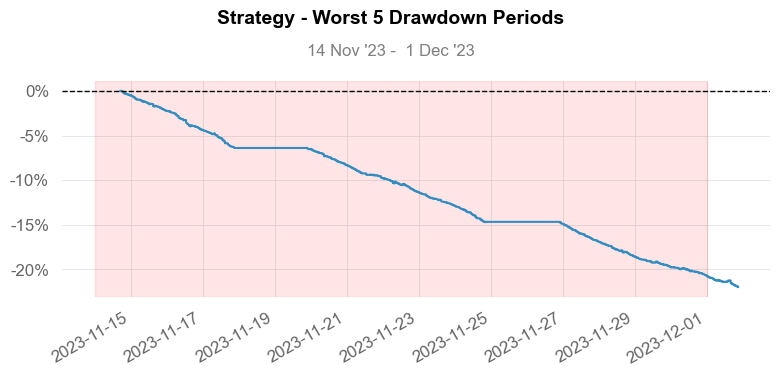

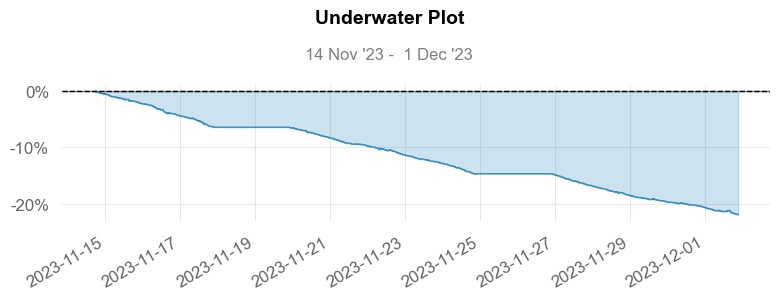

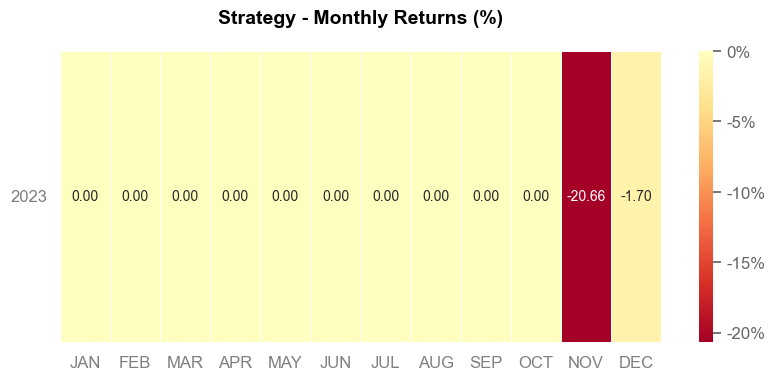

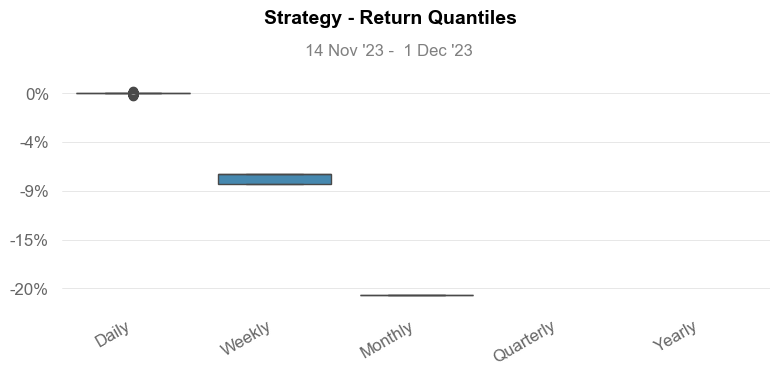

In [27]:
model_name="PPO - GRU"
tic_name= pair.split("/")[1].split(".")[0].split("_")[0]
period = pair.split("/")[0].split("_")[1]
train_df, test_df= load_and_preprocess_data(pair)
env_train , env_trade = setup_trading_environment(train_df=train_df, test_df=test_df, window_size=10)
model = train_model(env_train,  model_type=PPO, total_timesteps=5000)

action_stats,info = predict_actions_and_visualize(env=env_trade,model=model,tic_name=tic_name, model_name=model_name, period=period)
import quantstats as qs 
start_index=10
df = test_df
net_worth = pd.Series(env_trade.unwrapped.history['total_profit'], index=df.index[start_index+1:len(df)])
returns = net_worth.pct_change().iloc[1:]
# metrics = full(returns, tic_name=tic_name, model_name=model_name)
qs.reports.full(returns)
# Các giá trị cần ghi
# sell_value = action_stats[Actions.Sell]
# buy_value = action_stats[Actions.Buy]
# total_reward = info["total_reward"]
# total_profit = info["total_profit"]
# import csv
# # Đường dẫn đến file CSV
# csv_file_path = f'{tic_name}-{model_name}.csv'

# # Các giá trị cần ghi
# sell_value = action_stats[Actions.Sell]
# buy_value = action_stats[Actions.Buy]
# total_reward = info["total_reward"]
# total_profit = info["total_profit"]

# # Mở file CSV ở chế độ ghi và ghi các giá trị vào file
# with open(csv_file_path, mode='a', newline='') as file:
#     writer = csv.writer(file)
    
#     # Ghi các giá trị vào file dưới dạng hàng mới
#     writer.writerow(['Action Sell', sell_value])
#     writer.writerow(['Action Buy', buy_value])
#     writer.writerow(['Total Reward', total_reward])
#     writer.writerow(['Total Profit', total_profit])
#     writer.writerow(['Ticket', tic_name])
#     writer.writerow(['Model', model_name])

# print(f"Đã ghi thông tin vào {csv_file_path}")